In [4]:
import os
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models 
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import shutil
import numpy as np 

try:
    os.chdir("/Users/sevvalarslan/projects/SkinDataset")
    print("Çalışma dizini:", os.getcwd())
except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı. Lütfen yolu kontrol edin.")

src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)


Çalışma dizini: /Users/sevvalarslan/projects/SkinDataset


In [5]:
metadata_file = "HAM10000_metadata.csv"
metadata = []
with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

label_map = {"akiec": 0, "bcc": 1, "bkl": 2, "df": 3, "mel": 4, "nv": 5, "vasc": 6}
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"] 

data_list = []
for item in metadata:
    img_id = item["image_id"]
    if item["dx"] in label_map:
        label = label_map[item["dx"]]
        img_path = os.path.join(dst_dir, img_id + ".jpg")
        if os.path.exists(img_path):
            data_list.append((img_path, label))

# Train/Val/Test Split
from sklearn.model_selection import StratifiedKFold

X = [path for path, label in data_list]
y = [label for path, label in data_list]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_idx, test_idx = next(skf.split(X, y))

train_data = [(X[i], y[i]) for i in train_idx]
test_data  = [(X[i], y[i]) for i in test_idx]
test_list  = test_data


# Train içinden Val ayır
train_idx2, val_idx = next(
    StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    .split(
        [train_data[i][0] for i in range(len(train_data))],
        [train_data[i][1] for i in range(len(train_data))]
    )
)

train_list = [train_data[i] for i in train_idx2]
val_list   = [train_data[i] for i in val_idx]

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 6409, Val: 1603, Test: 2003


In [6]:
IMG_SIZE = 224 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("DataLoader hazır! (224x224)")

DataLoader hazır! (224x224)


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU (MPS Modu) aktif.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("NVIDIA GPU (CUDA) kullanılıyor.")
else:
    device = torch.device("cpu")
    print("CPU kullanılıyor.")

print(f"Seçilen Cihaz: {device}")

GPU (MPS Modu) aktif.
Seçilen Cihaz: mps


In [8]:
# Transfer Learning ve Model Hazırlama
def get_advanced_model(model_name, num_classes=7, pretrained=True):
        
    print(f">> Model Yükleniyor: {model_name}...")
    
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.DEFAULT if pretrained else None
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
    else:
        raise ValueError("Geçersiz model ismi. 'resnet50' veya 'efficientnet_b0' kullanın.")

    return model.to(device)


Sınıf Dağılımı (Train): [209, 329, 703, 74, 712, 4291, 91]


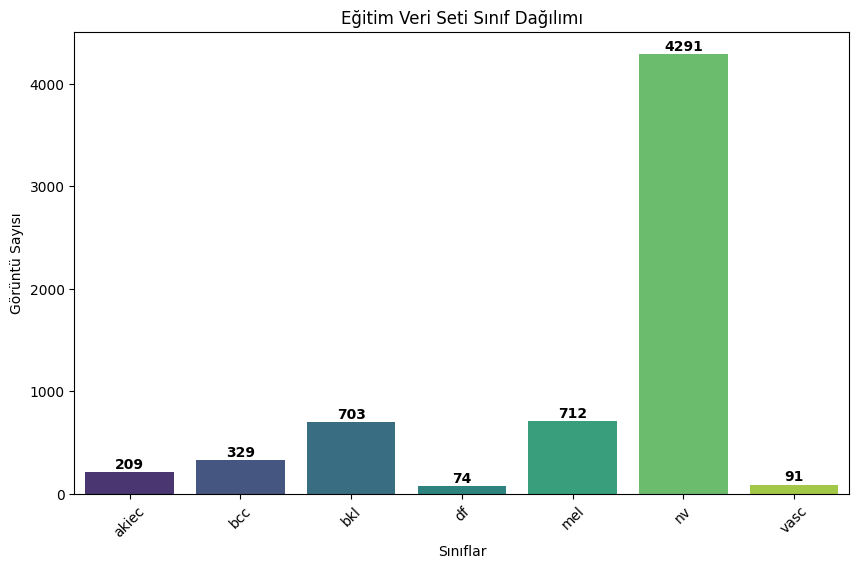

In [9]:
# Base modeldeki sınıf dengesizliğini çözme (class weights)
label_counts = [0] * 7
for _, label in train_list:
    label_counts[label] += 1

print("Sınıf Dağılımı (Train):", label_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=label_counts, hue=class_names, legend=False, palette="viridis")
plt.title("Eğitim Veri Seti Sınıf Dağılımı")
plt.xlabel("Sınıflar")
plt.ylabel("Görüntü Sayısı")
plt.xticks(rotation=45)
for i, count in enumerate(label_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')
plt.show()


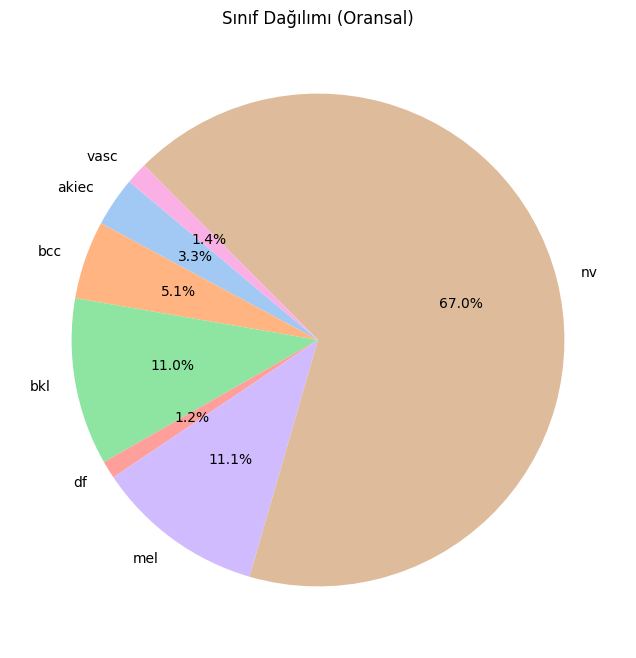

Hesaplanan Sınıf Ağırlıkları: tensor([0.1352, 0.0859, 0.0402, 0.3819, 0.0397, 0.0066, 0.3105],
       device='mps:0')


In [10]:
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Sınıf Dağılımı (Oransal)")
plt.show()
class_weights = 1.0 / torch.tensor(label_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() 
class_weights = class_weights.to(device)
print("Hesaplanan Sınıf Ağırlıkları:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [11]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss / len(loader), acc, f1

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)      
            total_loss += loss.item()        

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    avg_loss = total_loss / len(loader)      

    return avg_loss, acc, f1, all_labels, all_preds


In [12]:
def hyperparameter_experiment(model_name, lr, batch_size, epochs=3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = get_advanced_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for _ in range(epochs):
        train_epoch(model, train_loader, optimizer)

    val_loss, val_acc, val_f1, _, _ = eval_epoch(model, val_loader)
    return val_f1


In [ ]:
SECILEN_MODEL = "efficientnet_b0"

learning_rates = [1e-3, 1e-4]
batch_sizes = [16, 32]

print("\nHYPERPARAMETER TUNING TABLOSU")
print("-" * 50)
print(f"{'LR':<10}{'Batch':<10}{'Val F1':<10}")
print("-" * 50)

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        f1 = hyperparameter_experiment(SECILEN_MODEL, lr, bs)
        results.append((lr, bs, f1))
        print(f"{lr:<10}{bs:<10}{f1:<10.4f}")



HYPERPARAMETER TUNING TABLOSU
--------------------------------------------------
LR        Batch     Val F1    
--------------------------------------------------
>> Model Yükleniyor: efficientnet_b0...


In [39]:
SECILEN_MODEL = "efficientnet_b0" 
LR = 0.0001  # Transfer learning için düşük learning rate 
EPOCHS = 15 

model = get_advanced_model(SECILEN_MODEL)
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f" Eğitim Başlıyor: {SECILEN_MODEL} ---")

>> Model Yükleniyor: efficientnet_b0...
 Eğitim Başlıyor: efficientnet_b0 ---


In [54]:
train_losses = []
val_losses   = []   
train_accs   = []
val_accs     = []

best_f1 = -1
patience = 5
counter = 0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_f1, _, _ = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), f"Sevval_{SECILEN_MODEL}_best.pth")
        best_epoch = epoch
    else:
        counter += 1

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )

    if counter >= patience:
        print(f"Early stopping tetiklendi! (Best Epoch = {best_epoch}, Best F1 = {best_f1:.4f})")
        break





Epoch 1/15 | Train Loss: 0.1165 | Val Loss: 0.4238 | Train Acc: 0.9231 | Val Acc: 0.8634 | Val F1: 0.7807
Epoch 2/15 | Train Loss: 0.1101 | Val Loss: 0.4249 | Train Acc: 0.9331 | Val Acc: 0.8684 | Val F1: 0.7855
Epoch 3/15 | Train Loss: 0.1094 | Val Loss: 0.4363 | Train Acc: 0.9264 | Val Acc: 0.8646 | Val F1: 0.7769
Epoch 4/15 | Train Loss: 0.1181 | Val Loss: 0.4280 | Train Acc: 0.9273 | Val Acc: 0.8671 | Val F1: 0.7808
Epoch 5/15 | Train Loss: 0.1062 | Val Loss: 0.4200 | Train Acc: 0.9332 | Val Acc: 0.8721 | Val F1: 0.7849
Epoch 6/15 | Train Loss: 0.0977 | Val Loss: 0.4274 | Train Acc: 0.9296 | Val Acc: 0.8690 | Val F1: 0.7843
Epoch 7/15 | Train Loss: 0.0983 | Val Loss: 0.4330 | Train Acc: 0.9335 | Val Acc: 0.8702 | Val F1: 0.7822
Early stopping tetiklendi! (Best Epoch = 2, Best F1 = 0.7855)


In [55]:
# Fine-tuning grafik verileri
ft_train_losses = []
ft_val_losses   = []
ft_train_accs   = []
ft_val_accs     = []


In [56]:
#FINE TUNING 
model = get_advanced_model(SECILEN_MODEL)
model.load_state_dict(torch.load(f"Sevval_{SECILEN_MODEL}_best.pth"))

for param in model.parameters():
    param.requires_grad = True

FT_LR = 1e-5
FT_EPOCHS = 5

optimizer = optim.Adam(model.parameters(), lr=FT_LR)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2
)

best_ft_f1 = best_f1
ft_patience = 3
ft_counter = 0

for epoch in range(1, FT_EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_f1, _, _ = eval_epoch(model, val_loader)

    if val_f1 > best_ft_f1:
        best_ft_f1 = val_f1
        ft_counter = 0
        torch.save(model.state_dict(), f"Sevval_{SECILEN_MODEL}_finetuned.pth")
    else:
        ft_counter += 1

    scheduler.step(val_f1)

    print(
        f"FT Epoch {epoch}/{FT_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )

    if ft_counter >= ft_patience:
        print("Fine-tuning early stopping tetiklendi.")
        break



>> Model Yükleniyor: efficientnet_b0...
FT Epoch 1/5 | Train Loss: 0.1103 | Val Loss: 0.4457 | Train Acc: 0.9260 | Val Acc: 0.8628 | Val F1: 0.7778
FT Epoch 2/5 | Train Loss: 0.0983 | Val Loss: 0.4253 | Train Acc: 0.9331 | Val Acc: 0.8709 | Val F1: 0.7915
FT Epoch 3/5 | Train Loss: 0.0926 | Val Loss: 0.4294 | Train Acc: 0.9343 | Val Acc: 0.8646 | Val F1: 0.7798
FT Epoch 4/5 | Train Loss: 0.0998 | Val Loss: 0.4252 | Train Acc: 0.9332 | Val Acc: 0.8677 | Val F1: 0.7844
FT Epoch 5/5 | Train Loss: 0.1037 | Val Loss: 0.4499 | Train Acc: 0.9298 | Val Acc: 0.8621 | Val F1: 0.7791
Fine-tuning early stopping tetiklendi.


In [60]:
for epoch in range(1, FT_EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_f1, _, _ = eval_epoch(model, val_loader)

    ft_train_losses.append(train_loss)
    ft_val_losses.append(val_loss)
    ft_train_accs.append(train_acc)
    ft_val_accs.append(val_acc)

    if val_f1 > best_ft_f1:
        best_ft_f1 = val_f1
        torch.save(model.state_dict(), f"Sevval_{SECILEN_MODEL}_finetuned.pth")
        
    scheduler.step(val_f1)

    print(
        f"FT Epoch {epoch}/{FT_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )


FT Epoch 1/5 | Train Loss: 0.0832 | Val Loss: 0.4316 | Train Acc: 0.9423 | Val Acc: 0.8727 | Val F1: 0.7858
FT Epoch 2/5 | Train Loss: 0.0948 | Val Loss: 0.4604 | Train Acc: 0.9401 | Val Acc: 0.8596 | Val F1: 0.7748
FT Epoch 3/5 | Train Loss: 0.0881 | Val Loss: 0.4317 | Train Acc: 0.9406 | Val Acc: 0.8696 | Val F1: 0.7900
FT Epoch 4/5 | Train Loss: 0.0922 | Val Loss: 0.4429 | Train Acc: 0.9363 | Val Acc: 0.8665 | Val F1: 0.7804
FT Epoch 5/5 | Train Loss: 0.0826 | Val Loss: 0.4209 | Train Acc: 0.9440 | Val Acc: 0.8677 | Val F1: 0.7808


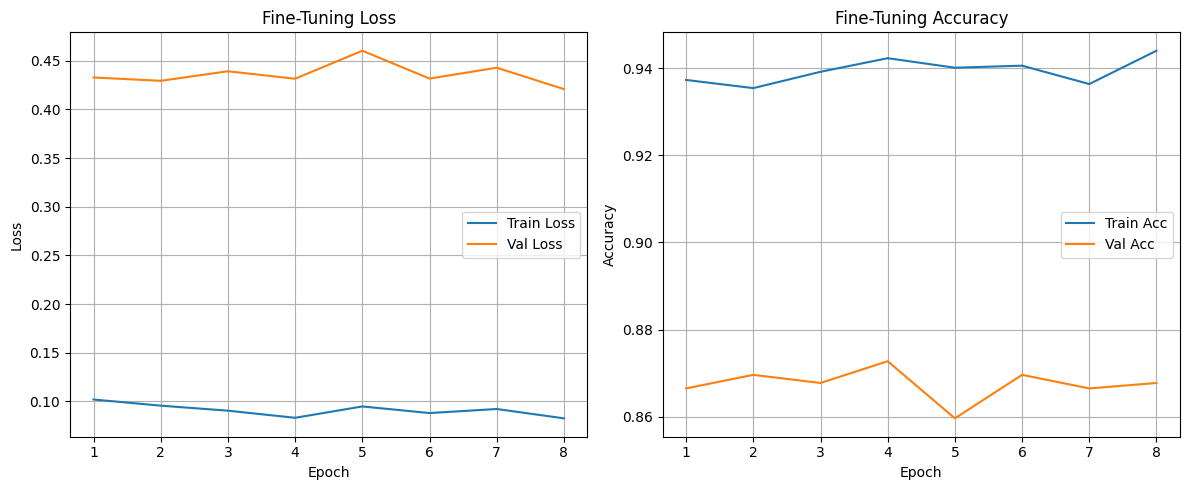

In [61]:
def plot_finetune_curves():
    epochs = range(1, len(ft_train_losses) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, ft_train_losses, label="Train Loss")
    plt.plot(epochs, ft_val_losses, label="Val Loss")
    plt.title("Fine-Tuning Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs, ft_train_accs, label="Train Acc")
    plt.plot(epochs, ft_val_accs, label="Val Acc")
    plt.title("Fine-Tuning Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_finetune_curves()


In [62]:
model.load_state_dict(torch.load(f"Sevval_{SECILEN_MODEL}_finetuned.pth"))

test_loss, test_acc, test_f1, test_labels, test_preds = eval_epoch(model, test_loader)

print(f"TEST Accuracy: {test_acc:.4f}")
print(f"TEST F1 Score: {test_f1:.4f}")


TEST Accuracy: 0.8632
TEST F1 Score: 0.8101


In [63]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(test_labels, test_preds)
print(f"TEST Balanced Accuracy: {balanced_acc:.4f}")


TEST Balanced Accuracy: 0.8274


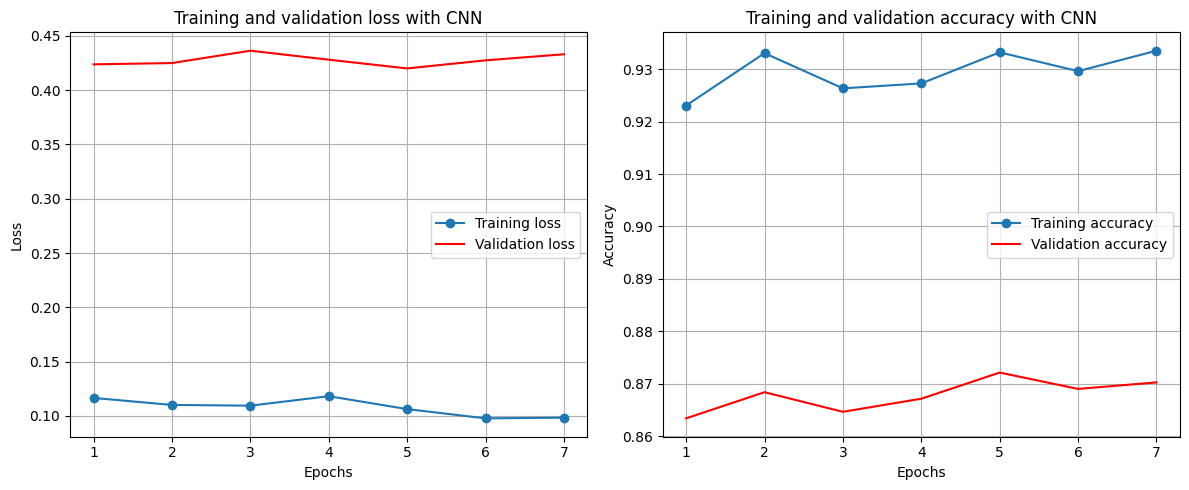

In [64]:
def plot_training_curves():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label="Training loss")
    plt.plot(epochs, val_losses, 'r-', label="Validation loss")
    plt.title("Training and validation loss with CNN")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'o-', label="Training accuracy")
    plt.plot(epochs, val_accs, 'r-', label="Validation accuracy")
    plt.title("Training and validation accuracy with CNN")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves()

In [65]:
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.77      0.66      0.71        65
         bcc       0.73      0.91      0.81       103
         bkl       0.73      0.78      0.75       220
          df       0.87      0.87      0.87        23
         mel       0.61      0.74      0.67       223
          nv       0.96      0.90      0.93      1341
        vasc       0.93      0.93      0.93        28

    accuracy                           0.86      2003
   macro avg       0.80      0.83      0.81      2003
weighted avg       0.87      0.86      0.87      2003



In [66]:
cancer_classes = ["mel", "bcc", "akiec"]

binary_true = [
    1 if class_names[label] in cancer_classes else 0
    for label in test_labels
]

binary_pred = [
    1 if class_names[pred] in cancer_classes else 0
    for pred in test_preds
]

print("\nBINARY (KANSERLİ / KANSER DEĞİL) CLASSIFICATION REPORT")
print(classification_report(
    binary_true,
    binary_pred,
    target_names=["Benign", "Malign"],
    zero_division=0
))



BINARY (KANSERLİ / KANSER DEĞİL) CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.96      0.92      0.94      1612
      Malign       0.71      0.82      0.76       391

    accuracy                           0.90      2003
   macro avg       0.83      0.87      0.85      2003
weighted avg       0.91      0.90      0.90      2003



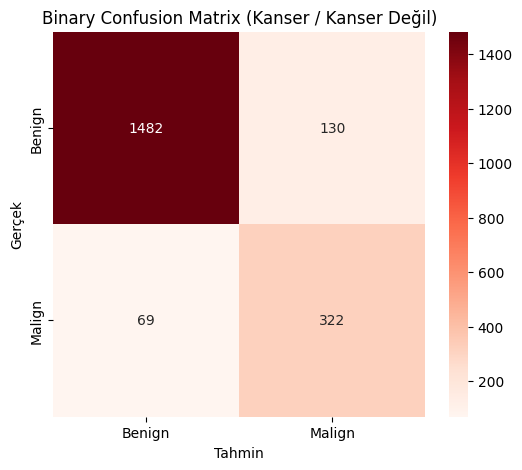

In [67]:
from sklearn.metrics import confusion_matrix

binary_cm = confusion_matrix(binary_true, binary_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    binary_cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Benign", "Malign"],
    yticklabels=["Benign", "Malign"]
)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Binary Confusion Matrix (Kanser / Kanser Değil)")
plt.show()


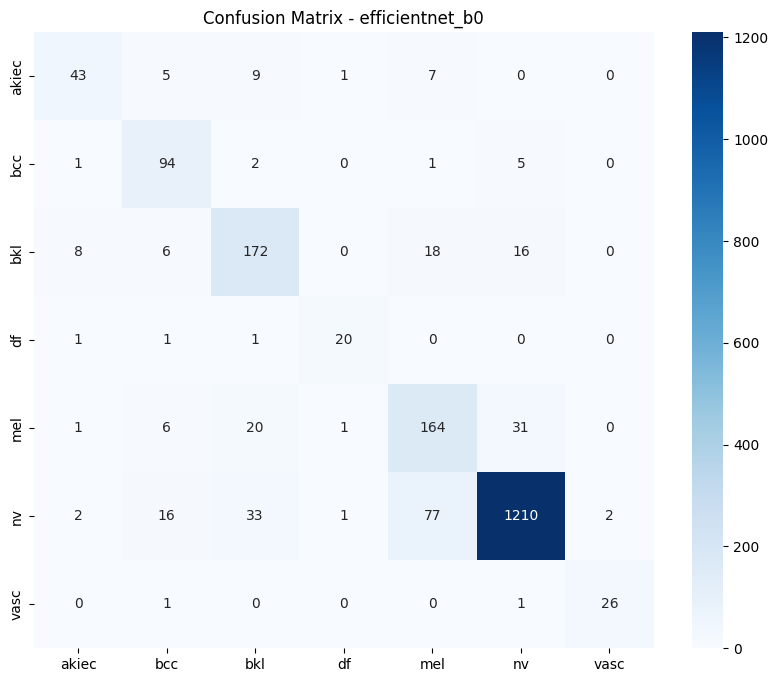

In [68]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {SECILEN_MODEL}")
plt.show()

ROC verileri hesaplanıyor...


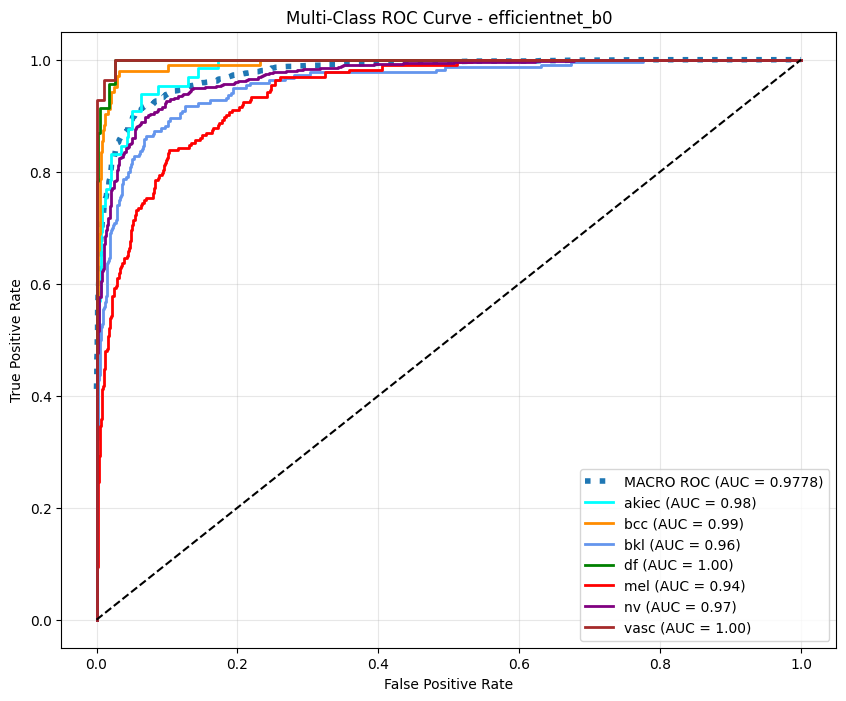


ROC-AUC SONUÇLARI
Manual Macro ROC-AUC   : 0.9778
Sklearn Macro ROC-AUC  : 0.9776
Sklearn Weighted ROC-AUC: 0.9688


In [69]:
# Roc-Auc Analizi
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

def plot_multiclass_roc(model, loader, num_classes=7):
    model.eval()
    y_test = []
    y_score = []

    print("ROC verileri hesaplanıyor...")
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = F.softmax(outputs, dim=1)
            
            y_test.extend(y.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    y_test = label_binarize(y_test, classes=range(num_classes))
    y_score = np.array(y_score)

    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # MANUAL MACRO ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # ROC PLOT 
    plt.figure(figsize=(10, 8))
    plt.plot(
        all_fpr,
        mean_tpr,
        label=f"MACRO ROC (AUC = {roc_auc['macro']:.4f})",
        linestyle=":",
        linewidth=4
    )

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multi-Class ROC Curve - {SECILEN_MODEL}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # SKLEARN ROC-AUC 
    roc_auc_macro_sklearn = roc_auc_score(
        y_test,
        y_score,
        multi_class="ovr",
        average="macro"
    )

    roc_auc_weighted_sklearn = roc_auc_score(
        y_test,
        y_score,
        multi_class="ovr",
        average="weighted"
    )

    print("\nROC-AUC SONUÇLARI")
    print(f"Manual Macro ROC-AUC   : {roc_auc['macro']:.4f}")
    print(f"Sklearn Macro ROC-AUC  : {roc_auc_macro_sklearn:.4f}")
    print(f"Sklearn Weighted ROC-AUC: {roc_auc_weighted_sklearn:.4f}")

    return {
        "macro_manual": roc_auc["macro"],
        "macro_sklearn": roc_auc_macro_sklearn,
        "weighted_sklearn": roc_auc_weighted_sklearn
    }


roc_auc = plot_multiclass_roc(model, test_loader)


In [70]:
if SECILEN_MODEL == "efficientnet_b0":
    print("EfficientNet daha az parametre ile daha yüksek genelleme başarısı sağlamıştır.")
else:
    print("ResNet50 derinliği sayesinde bazı sınıflarda daha yüksek recall üretmiştir.")


EfficientNet daha az parametre ile daha yüksek genelleme başarısı sağlamıştır.


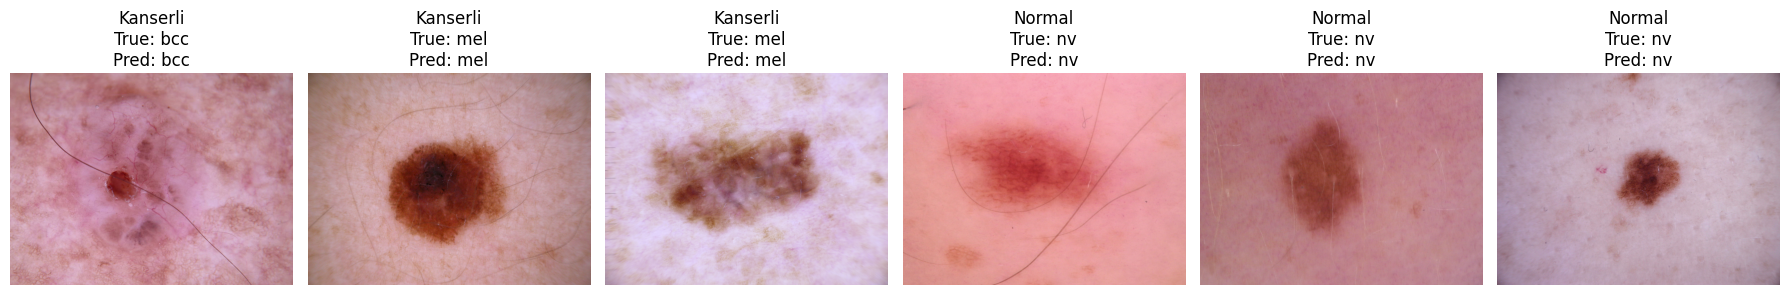

In [71]:
##Kanserli vs Normal Deri Lezyonu Örnekleri
def show_example_images_random(model, dataset, num_examples=5):
    model.eval()
    
    cancer_classes = ["mel", "bcc", "akiec"]
    normal_class = "nv"
    
    cancer_imgs = [(p, l) for p, l in dataset.data_list if class_names[l] in cancer_classes]
    normal_imgs = [(p, l) for p, l in dataset.data_list if class_names[l] == normal_class]

    cancer_samples = random.sample(cancer_imgs, min(num_examples, len(cancer_imgs)))
    normal_samples = random.sample(normal_imgs, min(num_examples, len(normal_imgs)))

    examples = cancer_samples + normal_samples
    titles = ["Kanserli"] * len(cancer_samples) + ["Normal"] * len(normal_samples)

    plt.figure(figsize=(3 * len(examples), 5))

    for i, ((img_path, label), title) in enumerate(zip(examples, titles)):
        image = Image.open(img_path).convert("RGB")
        image_tensor = val_test_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            pred = output.argmax(dim=1).item()

        plt.subplot(1, len(examples), i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{title}\nTrue: {class_names[label]}\nPred: {class_names[pred]}")

    plt.tight_layout()
    plt.show()

show_example_images_random(model, test_dataset, num_examples=3)


In [72]:
cancer_classes = ["mel", "bcc", "akiec"]

def to_binary(label):
    if class_names[label] in cancer_classes:
        return "Kanserli"
    else:
        return "Kanser Değil"


In [73]:
def visualize_feature_maps(model, image_path, target_layer, num_maps=16):
    model.eval()
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hook = target_layer.register_forward_hook(hook_fn)

    image = Image.open(image_path).convert("RGB")
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        model(input_tensor)

    hook.remove()

    feature_maps = activations[0].cpu().squeeze(0)

    plt.figure(figsize=(12, 12))
    for i in range(min(num_maps, feature_maps.shape[0])):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap="viridis")
        plt.axis("off")
        plt.title(f"Map {i}")

    plt.suptitle("Feature Map Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()


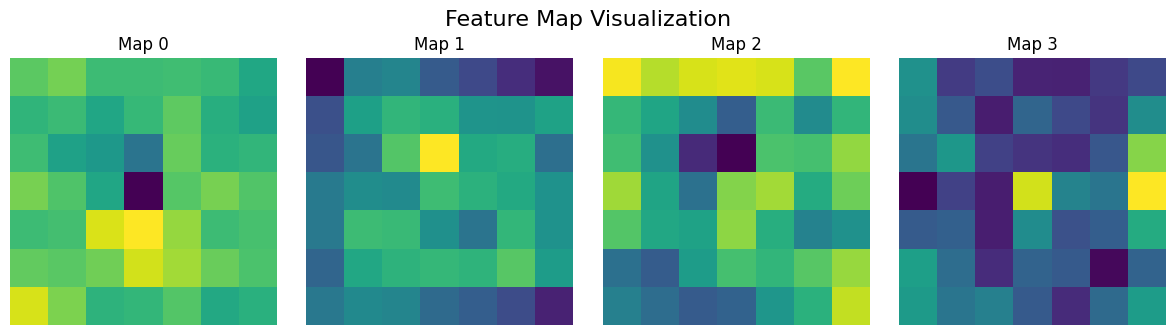

In [74]:
sample_img, _ = test_dataset.data_list[0]

if SECILEN_MODEL == "efficientnet_b0":
    layer = model.features[6]
else:
    layer = model.layer4[-1]

visualize_feature_maps(
    model=model,
    image_path=sample_img,
    target_layer=layer,
    num_maps=4
)


In [75]:
if SECILEN_MODEL == "efficientnet_b0":
    target_layer = model.features[-1]
else:
    target_layer = model.layer4[-1]


In [76]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        score = output[:, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [77]:
def overlay_cam(image_pil, cam, alpha=0.4):
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(image_pil.size)
    cam = np.array(cam)

    heatmap = np.stack([cam, np.zeros_like(cam), np.zeros_like(cam)], axis=-1)
    overlay = np.array(image_pil) * (1 - alpha) + heatmap * alpha
    return overlay.astype(np.uint8)


In [78]:
def show_gradcam_binary_examples(model, dataset, target_layer=None, num_examples=5, save_path=None):
    model.eval()

    if target_layer is None:
        if hasattr(model, "layer4"):
            target_layer = model.layer4[-1]
        else:
            target_layer = model.features[-1]

    examples = random.sample(dataset.data_list, num_examples)
    plt.figure(figsize=(15, 5))

    for i, (img_path, label) in enumerate(examples):
        image = Image.open(img_path).convert("RGB")
        input_tensor = val_test_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

        cam_generator = GradCAM(model, target_layer)
        cam = cam_generator.generate(input_tensor, pred_class)

        cam = np.uint8(255 * cam)
        cam = np.stack([cam, cam, cam], axis=-1)
        cam = Image.fromarray(cam).resize(image.size)

        overlay = np.array(image) * 0.6 + np.array(cam) * 0.4
        overlay = overlay.astype(np.uint8)

        plt.subplot(1, num_examples, i + 1)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(
            f"Gerçek: {to_binary(label)}\nTahmin: {to_binary(pred_class)}",
            fontsize=10
        )

    plt.suptitle(f"{num_examples} GradCAM Örnekleri", fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


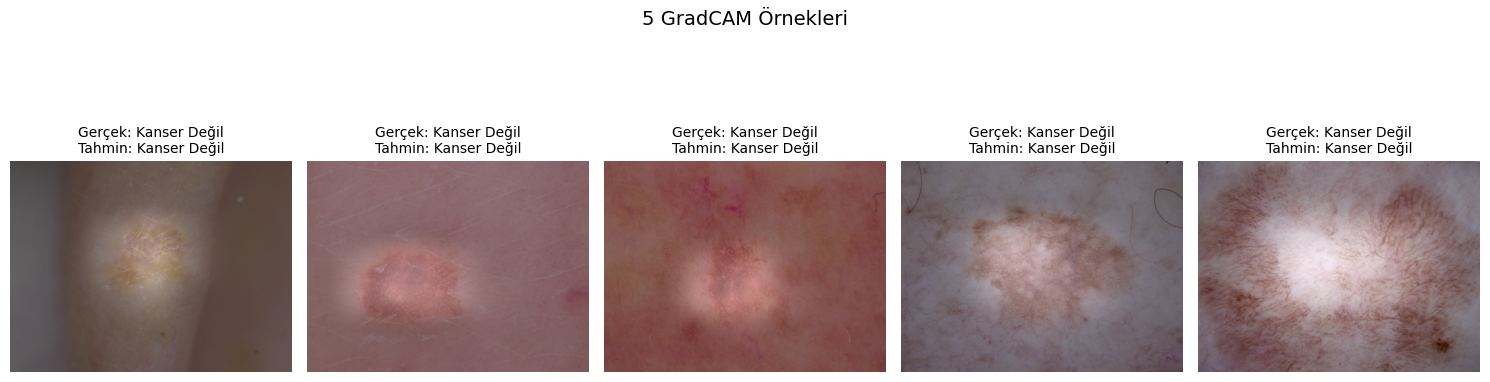

In [80]:
show_gradcam_binary_examples(model, test_dataset, num_examples=5, save_path="gradcam_examples.png")


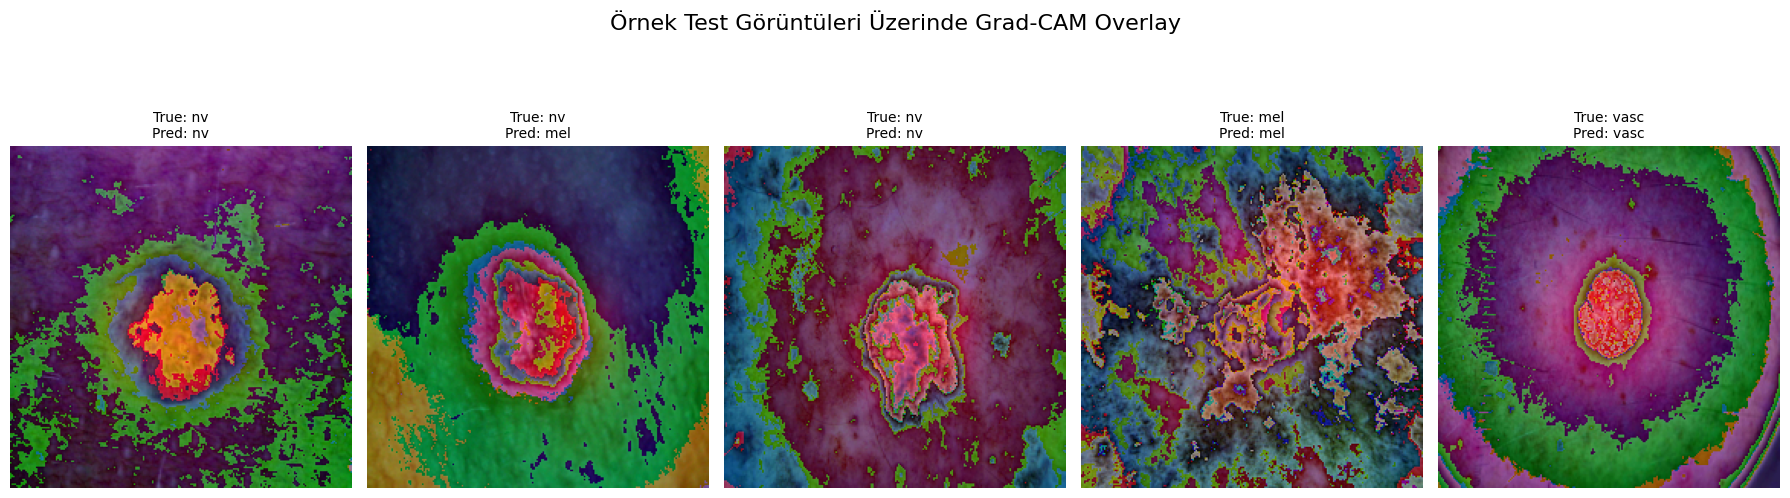

In [81]:
plt.figure(figsize=(18, 6))

grad_cam = GradCAM(model, target_layer)

num_examples = 5
indices = random.sample(range(len(test_dataset)), num_examples)

for i, idx in enumerate(indices):
    img_tensor, label = test_dataset[idx]
    img_input = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_input)
        pred = output.argmax(dim=1).item()

    cam = grad_cam.generate(img_input, pred)

    img_pil = transforms.ToPILImage()(img_tensor.cpu())
    overlayed_img = overlay_cam(img_pil, cam)

    plt.subplot(1, num_examples, i + 1)
    plt.imshow(overlayed_img)
    plt.title(
        f"True: {class_names[label]}\nPred: {class_names[pred]}",
        fontsize=10
    )
    plt.axis("off")

plt.suptitle("Örnek Test Görüntüleri Üzerinde Grad-CAM Overlay", fontsize=16)
plt.tight_layout()
plt.show()


In [82]:
model_summary = {
    "Model": SECILEN_MODEL,
    "Accuracy": test_acc,
    "Balanced Accuracy": balanced_acc,
    "Macro F1": test_f1,
    "ROC-AUC": roc_auc["weighted_sklearn"]
}

print("\nMODEL ÖZETİ")
print("-" * 60)
for k, v in model_summary.items():
    print(f"{k:<20}: {v}")



MODEL ÖZETİ
------------------------------------------------------------
Model               : efficientnet_b0
Accuracy            : 0.8632051922116825
Balanced Accuracy   : 0.8274074807417318
Macro F1            : 0.8100982482556782
ROC-AUC             : 0.9688473395913992


In [83]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds, average=None, labels=range(7))

print("\n" + "="*60)
print(f"TABLO 2: {SECILEN_MODEL} İÇİN SINIF BAZLI BAŞARIM METRİKLERİ")
print("="*60)
print(f"{'Sınıf':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
print("-" * 60)

for i, name in enumerate(class_names):
    print(f"{name:<10} | {precision[i]:.4f}     | {recall[i]:.4f}     | {f1[i]:.4f}     | {support[i]:<10}")
print("-" * 60)


TABLO 2: efficientnet_b0 İÇİN SINIF BAZLI BAŞARIM METRİKLERİ
Sınıf      | Precision  | Recall     | F1-Score   | Support   
------------------------------------------------------------
akiec      | 0.7679     | 0.6615     | 0.7107     | 65        
bcc        | 0.7287     | 0.9126     | 0.8103     | 103       
bkl        | 0.7257     | 0.7818     | 0.7527     | 220       
df         | 0.8696     | 0.8696     | 0.8696     | 23        
mel        | 0.6142     | 0.7354     | 0.6694     | 223       
nv         | 0.9580     | 0.9023     | 0.9293     | 1341      
vasc       | 0.9286     | 0.9286     | 0.9286     | 28        
------------------------------------------------------------
